# Visualization with Polarplot

(Figure 5 in paper).

Figure panels:

A) Figure with CS grid on polar coordinates

B) Figure with equal area grid

C) Figure with data - to be explained below

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import apexpy
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader

Re = 6371.2e3    # Earth radius
HI = 110e3       # Ionospheric altitude
time = dt.datetime(2005, 9, 10)

Make a grid:

In [2]:
L, W, Lres, Wres = 5000e3, 5000e3, 100e3, 100e3 # m
position = (-88, 72) # geographic lon, lat of center of grid
orientation = 45     # angle defining orientation of xi-axis
projection = lompe.cs.CSprojection(position, orientation)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set grid to ionospheric altitude

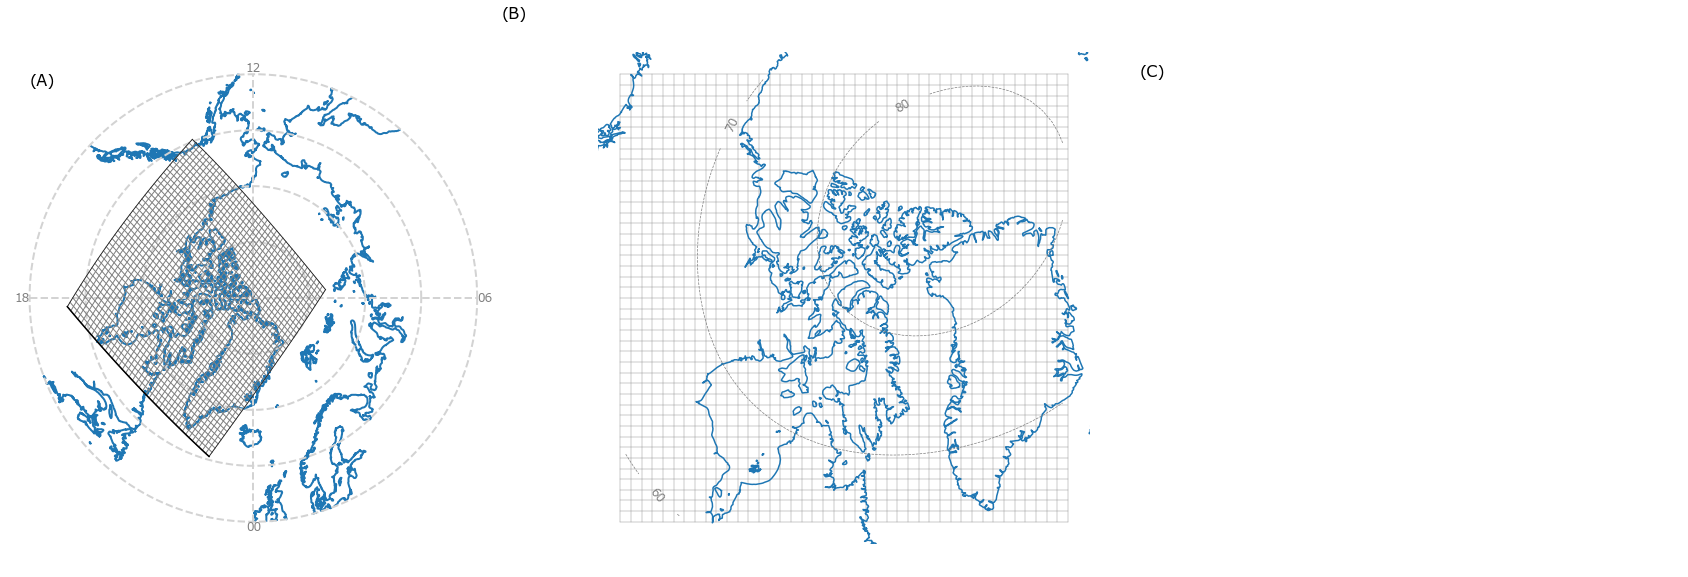

In [3]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (30,10))
spec = fig.add_gridspec(1, 3)
axs = {}

axs['polar'] = fig.add_subplot(spec[:, 0:1])
axs['grid' ] = fig.add_subplot(spec[:, 1:2])
axs['data' ] = fig.add_subplot(spec[:, 2:])

# remove borders from axes and set aspect
for key in axs.keys():
    axs[key].set_axis_off()
    axs[key].set_aspect('equal')

# polarplot
apex = apexpy.Apex(time, refh=HI*1e-3)

pax = lompe.visualization.Polarsubplot(axs['polar'], minlat = 50, plotgrid = True, linewidth=2)
pax.writeMLTlabels(color = 'grey', mlat = 50, fontsize = 12)

# coastlines
shpfilename = shpreader.natural_earth(resolution='50m', category='physical', name='coastline')
reader = shpreader.Reader(shpfilename)
coastlines = reader.records()
multilinestrings = []
for coastline in coastlines:
    if coastline.geometry.geom_type == 'MultiLineString':
        multilinestrings.append(coastline.geometry)
        continue

    lon, lat = np.array(coastline.geometry.coords[:]).T 
    lompe.visualization.polarplot_coastline(lon, lat, pax, apex, time, zorder = 1, color='C0')

for mls in multilinestrings:
    for ls in mls:
        lon, lat = np.array(ls.coords[:]).T 
        lompe.visualization.polarplot_coastline(lon, lat, pax, apex, time, zorder = 1, color='C0')

# grid on polarplot
for lon, lat in grid.get_grid_boundaries():
    mlat, mlon = apex.geo2apex(lat, lon, height=HI*1e-3)
    mlt = apex.mlon2mlt(mlon, time)
    pax.plot(mlat, mlt, color = 'grey', linewidth = 1)
    
# grid outline on polarplot
xs = (grid.lon_mesh[0, :], grid.lon_mesh[-1, :], grid.lon_mesh[:, 0], grid.lon_mesh[:, -1])
ys = (grid.lat_mesh[0, :], grid.lat_mesh[-1, :], grid.lat_mesh[:, 0], grid.lat_mesh[:, -1])
for i, c in enumerate(zip(xs, ys)):
    lon, lat = c
    mlat, mlon = apex.geo2apex(lat, lon, 110)
    mlt = apex.mlon2mlt(mlon, time)
    pax.plot(mlat, mlt, color = 'black', linewidth = 1.5 if i == 0 else .5, zorder = 2)

####### grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    axs['grid'].plot(xi, eta, color = 'grey', linewidth = .4)
xlim, ylim = axs['grid'].get_xlim(), axs['grid'].get_ylim()

# coastlines
for cl in grid.projection.get_projected_coastlines():
    axs['grid'].plot(cl[0], cl[1], color = 'C0')

# add magnetic latitude contours
mlat, mlon = apex.geo2apex(grid.lat, grid.lon, height = HI*1e-3)
co = axs['grid'].contour(grid.xi, grid.eta, mlat, linestyles = '--', colors='grey', linewidths=.7,
                         levels = np.r_[-80:81:10])
axs['grid'].clabel(co, co.levels, inline = True, fontsize = 12)

axs['grid'].set_xlim(xlim)
axs['grid'].set_ylim(ylim)

# add subfigure letters
axs['polar'].text(-1, 0.95,  '(A)', fontsize=16)
axs['grid' ].text(-0.5, 0.4, '(B)', fontsize=16)
axs['data' ] .text(-0.1, 0.95, '(C)', fontsize=16)

fig.subplots_adjust()

# save figure
fig.savefig('./output_figures/Polarplotexample.png')
fig.savefig('./output_figures/Polarplotexample.pdf')